<a href="https://colab.research.google.com/github/klsharma22/TensorflowCertifcationCourse/blob/main/Milestone%20Projects/09_milestone_project_2_Skim_Lit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 2: SkimLit

The purpose of this notebook is to build an NLP model to make reading medical abstracts easier.

The paper we're replicating is avaliable here: [PubMed 200k RCT](https://arxiv.org/abs/1710.06071)

Reading through the paper above, we see that the model architecture that they use to achieve their best results is availbale here: [Neural Networks for Joint Sentence Classification](https://arxiv.org/abs/1612.05251)

## Get data

Since we are replicating the model from the above paper, let's use their data.

[Dataset](https://github.com/Franck-Dernoncourt/pubmed-rct)

In [2]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 50.44 MiB/s, done.
Resolving deltas: 100% (15/15), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [3]:
# Check what files are in the PubMed20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [4]:
# Start our experiments using the 20k dataset with numbers replaced by '@' sign
# data_dir = '/Users/klsharma22/Desktop/TensorflowCertifcationCourse/Milestone Projects/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'
data_dir = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/'

In [5]:
# Check all of the filenames in the target directory
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

Now we've got some text data, it's time to get one with it.

In [6]:
# Create a function to read the lines of the document
def get_lines(filename):
    '''
    Reads filename and returns the lines of text as a list.

    Args:
        filename (str): Path of filename

    Returns:
        A list of string with one string per line from the target filename
    '''

    with open(filename, 'r') as f:
        return f.readlines()

In [7]:
# Let's read in the training lines
train_lines = get_lines(filenames[2])
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look

Representation of the data:

```
[{'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'xyz',
    'total_lines': 11}]
```

In [8]:
def preprocess_text_with_line_numbers(filename):
    '''
    Returns a list of dictionary of abstract line data.

    Takes in filename, reads it contents and sorts through each line, extracting things like the target label, the text of the sentence, number of snetences and what sentence number line is.
    '''
    input_lines = get_lines(filename)
    abstract_lines = ""
    abstract_samples = []

    for line in input_lines: # if the line is the id number
        if line.startswith("###"):
            abstract_id = line
            abstract_lines = ""
        elif line.isspace(): # if it is the new line
            abstract_line_split = abstract_lines.splitlines()

            for line_number, abstract_line in enumerate(abstract_line_split):
                line_data = {}
                target_text_split = abstract_line.split('\t')
                line_data['target'] = target_text_split[0]
                line_data['text'] = target_text_split[1].lower()
                line_data['line_number'] = line_number
                line_data['total_lines'] = len(abstract_line_split) - 1
                abstract_samples.append(line_data)

        else: # if it is the text
            abstract_lines += line

    return abstract_samples

In [9]:
train_samples = preprocess_text_with_line_numbers(filenames[2])
val_samples = preprocess_text_with_line_numbers(filenames[1])
test_samples = preprocess_text_with_line_numbers(filenames[0])

len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [10]:
# Check the first abstract
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that we have our data in the form of dictionary, let's create a dataframe

In [11]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [12]:
# Distribution of labels
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

<Axes: ylabel='Frequency'>

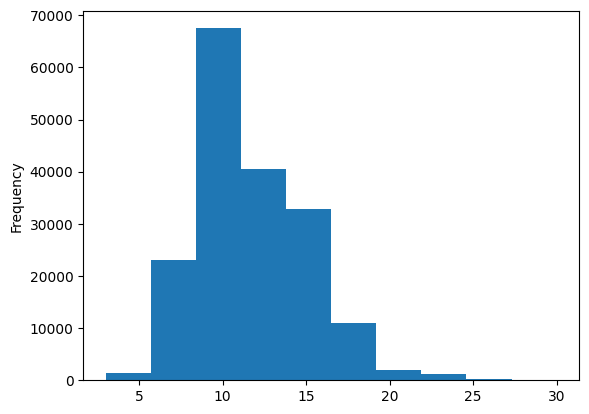

In [13]:
# Let's check length of different lines
train_df['total_lines'].plot.hist()

### Get a lists of sentences

In [14]:
# Convert abstract text lines into lists
train_sentences = train_df['text'].to_list()
val_sentences = val_df['text'].to_list()
test_sentences = test_df['text'].to_list()

len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

## Make numeric labels

In [15]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder(sparse= False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))

len(train_labels_one_hot), len(val_labels_one_hot), len(test_labels_one_hot)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


(180040, 30212, 30135)

## Label encode labels

In [16]:
# Extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labels_encoded = label_encoder.transform(test_df['target'].to_numpy())

train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [17]:
# get class names and number of classes from LabelEncoder
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_

num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Experiments

### Model 0: Getting a baseling

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline

model_0 = Pipeline([
    ('tf-idf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X= train_sentences,
            y= train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [19]:
# Evaluate baseline model on validation dataset
model_0.score(X= val_sentences,
              y= val_labels_encoded)

0.7218323844829869

In [20]:
# Make prediction using baseline model
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

#### Download helper function script for evaluation

In [21]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-03-15 08:01:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-03-15 08:01:13 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [22]:
from helper_functions import calculate_results

In [23]:
# Calculate baseline results
baseline_results = calculate_results(y_true= val_labels_encoded,
                                     y_pred= baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [24]:
import tensorflow as tf

## Preparing our data for deep sequence models

Before we start building deep model, we've got tocreate vectorization and embedding layers

In [25]:
import numpy as np
from tensorflow.keras import layers

In [26]:
# how long is ech sentences on average
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sentence_len = np.mean(sent_lens)
avg_sentence_len

26.338269273494777

(array([1.6499e+04, 5.6664e+04, 5.2683e+04, 2.9050e+04, 1.3111e+04,
        5.6610e+03, 3.0490e+03, 1.5190e+03, 8.0800e+02, 4.3200e+02,
        2.2600e+02, 1.2800e+02, 7.7000e+01, 3.9000e+01, 3.0000e+01,
        1.5000e+01, 9.0000e+00, 8.0000e+00, 4.0000e+00, 8.0000e+00,
        7.0000e+00, 5.0000e+00, 1.0000e+00, 2.0000e+00, 3.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1.        ,  10.83333333,  20.66666667,  30.5       ,
         40.33333333,  50.16666667,  60.        ,  69.83333333,
         79.66666667,  89.5       ,  99.33333333, 109.16666667,
        119.        , 128.83333333, 138.66666667, 148.5       ,
        158.33333333, 168.16666667, 178.        , 187.83333333,
        197.66666667, 207.5       , 217.33333333, 227.16666667,
        237.        , 246.83333333, 256.66666667, 266.5       ,
        276.33333333, 286.16666667, 296.        ]),
 <BarContainer object of 30 artists>)

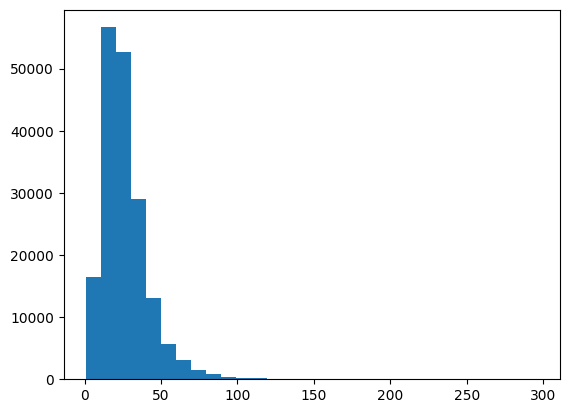

In [27]:
# What is the distribution of the sentences
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins= 30)

In [28]:
# How longof a sentence length covers 95% of examples
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [29]:
# maximum sequence length
max(sent_lens)

296

### Create text vectorizzer layer

We want to make a layer which converts text data into vectors

In [30]:
# Creating text vectorizer
max_vocab = 68000
text_vectorizer = layers.TextVectorization(max_tokens= max_vocab,
                                           output_sequence_length= output_seq_len)

In [31]:
# Adapt text vectorizer to training sentences
text_vectorizer.adapt(train_sentences)

In [32]:
# Test out text vectorizer on random sentences

import random
target_senteces = random.choice(train_sentences)
print(f"Text: {target_senteces}")
print(f"Length of Text: {len(target_senteces.split())}")
print(f"Vectorized: {text_vectorizer(target_senteces)}")

Text: primary outcomes were treatment success ( vein obliteration or abolition of reflux ) -lsb- corrected -rsb- at @weeks , and venous clinical severity score ( vcss ) at @weeks .
Length of Text: 30
Vectorized: [   56    75     9    19   611  1701 15673    16 41514     4  2032    46
  1977    45    15    53     3  1120    47   332   101 17677    15    53
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0]


In [33]:
# How many words in our training vocab
rct_20k_vocab = text_vectorizer.get_vocabulary()

print(f"Number of words in vocab: {len(rct_20k_vocab)}")
print(f"Most common words: {rct_20k_vocab[:5]}")
print(f"Least common words: {rct_20k_vocab[-5:]}")

Number of words in vocab: 64841
Most common words: ['', '[UNK]', 'the', 'and', 'of']
Least common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [34]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create an embedding layer

In [35]:
embedding = layers.Embedding(input_dim= len(rct_20k_vocab),
                             output_dim= 128,
                             mask_zero= True, # use masking to handle variable sequence length
                             name= 'token_embedding'
                             )

In [36]:
random_sentence = random.choice(train_sentences)
print(f"Text: {random_sentence}")
print(f"Embed: {embedding(text_vectorizer([random_sentence])).shape}")

Text: then , icsi was performed for all subjects of the two study groups with no statistically significant difference ( p > @ ) regarding the number of oocytes retrieved and the number of embryo transfer .
Embed: (1, 55, 128)


## Creating dataset

We're going to setup our data to run as fast as possible with tf.data API

In [37]:
# Turn our data into Tensorflow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [38]:
# Take the tensor_slice dataset and turn them into prefetch dataset
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

### Model 1: CNN 1D

In [39]:
inputs = layers.Input(shape= (1, ), dtype= 'string')
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(64, 5, activation= 'relu', padding='same', name= 'cnn_1d_layer')(x)
x = layers.GlobalAveragePooling1D(name= 'global_avg_pool_layer')(x)
outputs = layers.Dense(num_classes, activation= 'softmax', name= 'output_layer')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.legacy.Adam(),
                metrics= ['accuracy'])

model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 cnn_1d_layer (Conv1D)       (None, 55, 64)            41024     
                                                                 
 global_avg_pool_layer (Glo  (None, 64)                0         
 balAveragePooling1D)                                            
                                                             

In [40]:
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs= 5,
                              validation_data= val_dataset,
                              validation_steps= int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 7s 8ms/step - loss: 0.9115 - accuracy: 0.6397 - val_loss: 0.6799 - val_accuracy: 0.7457
Epoch 2/5
562/562 [==============================] - 5s 8ms/step - loss: 0.6525 - accuracy: 0.7594 - val_loss: 0.6331 - val_accuracy: 0.7746
Epoch 3/5
562/562 [==============================] - 5s 8ms/step - loss: 0.6146 - accuracy: 0.7757 - val_loss: 0.5937 - val_accuracy: 0.7869
Epoch 4/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5872 - accuracy: 0.7906 - val_loss: 0.5773 - val_accuracy: 0.7882
Epoch 5/5
562/562 [==============================] - 5s 8ms/step - loss: 0.5890 - accuracy: 0.7924 - val_loss: 0.5602 - val_accuracy: 0.7982


In [41]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5599 - accuracy: 0.8015


[0.559944748878479, 0.801469624042511]

In [42]:
model_1_pred = tf.argmax(model_1.predict(val_dataset), axis= 1).numpy()
model_1_pred

945/945 [==============================] - 2s 2ms/step


array([0, 0, 3, ..., 4, 4, 1])

In [43]:
# Calculate results
model_1_results = calculate_results(val_labels_encoded,
                                    model_1_pred)
model_1_results

{'accuracy': 80.14696147226267,
 'precision': 0.8018702546937242,
 'recall': 0.8014696147226268,
 'f1': 0.7985160376608847}

In [44]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [45]:
import tensorflow_hub as hub

In [46]:
sentence_encoder_layer = hub.KerasLayer("https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/TensorFlow2/variations/universal-sentence-encoder/versions/2",
                                        trainable= False,
                                        name= 'USE_layer')

### Model 2: Transfer Learning

In [47]:
inputs = layers.Input(shape= [], dtype= 'string', name= 'input_layer')
x = sentence_encoder_layer(inputs)
x = layers.Dense(128, activation= 'relu')(x)
outputs = layers.Dense(num_classes, activation= 'softmax', name= 'output_layer')(x)

model_2 = tf.keras.Model(inputs= inputs, outputs= outputs, name= 'model_2_USE')

model_2.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

In [48]:
model_2.summary()

Model: "model_2_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None,)]                 0         
                                                                 
 USE_layer (KerasLayer)      (None, 512)               256797824 
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 output_layer (Dense)        (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [49]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch= int(0.1 * len(train_dataset)),
                              epochs= 5,
                              validation_data= val_dataset,
                              validation_steps= int(0.1 * len(val_dataset)))

Epoch 1/5
562/562 [==============================] - 13s 14ms/step - loss: 0.9169 - accuracy: 0.6485 - val_loss: 0.7955 - val_accuracy: 0.6905
Epoch 2/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7670 - accuracy: 0.7031 - val_loss: 0.7516 - val_accuracy: 0.7048
Epoch 3/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7478 - accuracy: 0.7157 - val_loss: 0.7341 - val_accuracy: 0.7184
Epoch 4/5
562/562 [==============================] - 7s 13ms/step - loss: 0.7142 - accuracy: 0.7275 - val_loss: 0.7060 - val_accuracy: 0.7301
Epoch 5/5
562/562 [==============================] - 7s 12ms/step - loss: 0.7217 - accuracy: 0.7233 - val_loss: 0.6865 - val_accuracy: 0.7344


In [50]:

model_2_pred = tf.argmax(model_2.predict(val_dataset), axis= 1)
model_2_pred

945/945 [==============================] - 9s 9ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 2, 1])>

In [51]:
model_2_results = calculate_results(val_labels_encoded,
                                    model_2_pred)
model_2_results

{'accuracy': 73.62637362637363,
 'precision': 0.7322825257403595,
 'recall': 0.7362637362637363,
 'f1': 0.7305134400375042}

In [52]:
baseline_results, model_1_results

({'accuracy': 72.1832384482987,
  'precision': 0.7186466952323352,
  'recall': 0.7218323844829869,
  'f1': 0.6989250353450294},
 {'accuracy': 80.14696147226267,
  'precision': 0.8018702546937242,
  'recall': 0.8014696147226268,
  'f1': 0.7985160376608847})

### Model 3: CNN 1D with character embeddings

The paper we are replicating uses the combination of character and token embedding.

We've only used token embedding in the previous experiments. In order to replicate we need to do the similar steps.

#### Creating Character level tokenizer

In [53]:
train_sentences[:5]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .']

In [54]:
# Make a function which splits the sentence
def split_chars(text):
  return " ".join(list(text))

In [55]:
# Split data into character level
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [56]:
# What is the average chartacter length
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([2.2108e+04, 7.0583e+04, 5.3952e+04, 2.2391e+04, 7.4540e+03,
        2.2350e+03, 8.0200e+02, 2.8700e+02, 1.1800e+02, 4.9000e+01,
        2.9000e+01, 1.3000e+01, 8.0000e+00, 5.0000e+00, 1.0000e+00,
        2.0000e+00, 1.0000e+00, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000e+00, 7.02500e+01, 1.39500e+02, 2.08750e+02, 2.78000e+02,
        3.47250e+02, 4.16500e+02, 4.85750e+02, 5.55000e+02, 6.24250e+02,
        6.93500e+02, 7.62750e+02, 8.32000e+02, 9.01250e+02, 9.70500e+02,
        1.03975e+03, 1.10900e+03, 1.17825e+03, 1.24750e+03, 1.31675e+03,
        1.38600e+03]),
 <BarContainer object of 20 artists>)

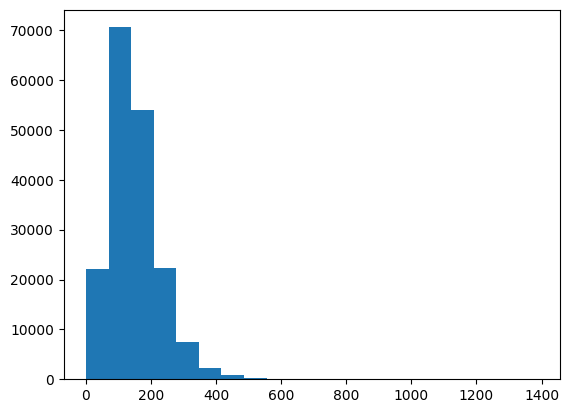

In [57]:
# Check the distribution of the character level
plt.hist(char_lens, bins= 20)

In [58]:
# Find what character lenght covers 95% of the training data
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [59]:
# Get all keyboard characters
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [60]:
# Create char level tokenizer
NUM_CHAR_TOKENS = len(alphabet) + 2 # 2 for space and OOV
char_vectorizer = layers.TextVectorization(max_tokens= NUM_CHAR_TOKENS,
                                           output_sequence_length= output_seq_char_len,
                                           name= 'character_tokenizer')

In [61]:
# Adapt character vectorizer
char_vectorizer.adapt(train_chars)

In [62]:
# Check for vocbulary
char_vocab = char_vectorizer.get_vocabulary()
len(char_vocab), char_vocab[:5], char_vocab[-5:]

(28, ['', '[UNK]', 'e', 't', 'i'], ['k', 'x', 'z', 'q', 'j'])

In [63]:
# Test character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Character-level sentence: {random_train_chars}")
print(f"Length of sentence: {len(random_train_chars.split())}")
print(f"Vectorized sentence: {len(char_vectorizer(random_train_chars))}")

Character-level sentence: i n t e r v e n t i o n a l   r e v i e w   a n d   f i n a l   c o m p l i a n c e   r e v i e w   s c o r e s   w e r e   a s s i g n e d   t o   e a c h   r a d i a t i o n   t h e r a p y   c a s e   a n d   c o m p a r e d   .
Length of sentence: 100
Vectorized sentence: 290


#### Creating a character level embedding

In [64]:
# Create char embedding layer
char_embedding = layers.Embedding(input_dim= len(char_vocab),
                                  output_dim= 25,
                                  mask_zero= True,
                                  name= 'character_embedding_layer')

In [65]:
# Test out character level embedding layer
print(f"Sentence: {random_train_chars}")
print(f"Lenght of embedded: {char_embedding(char_vectorizer(random_train_chars)).shape}")

Sentence: i n t e r v e n t i o n a l   r e v i e w   a n d   f i n a l   c o m p l i a n c e   r e v i e w   s c o r e s   w e r e   a s s i g n e d   t o   e a c h   r a d i a t i o n   t h e r a p y   c a s e   a n d   c o m p a r e d   .
Lenght of embedded: (290, 25)


In [77]:
# Create model
inputs = layers.Input(shape= (1, ), dtype= 'string', name= 'input_layer')
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(64, 5, name= 'cnn_1D_layer')(x)
x = layers.GlobalMaxPool1D(name= 'global_max_pool_layer')(x)
outputs = layers.Dense(len(class_names), activation= 'softmax', name= 'output_layer')(x)

model_3 = tf.keras.Model(inputs, outputs, name= 'model_3_cnn1D_char_embedding')

model_3.compile(loss= 'categorical_crossentropy',
                optimizer= tf.keras.optimizers.Adam(),
                metrics= ['accuracy'])

In [78]:
model_3.summary()

Model: "model_3_cnn1D_char_embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 1)]               0         
                                                                 
 character_tokenizer (TextV  (None, 290)               0         
 ectorization)                                                   
                                                                 
 character_embedding_layer   (None, 290, 25)           700       
 (Embedding)                                                     
                                                                 
 cnn_1D_layer (Conv1D)       (None, 286, 64)           8064      
                                                                 
 global_max_pool_layer (Glo  (None, 64)                0         
 balMaxPooling1D)                                                
                                      

In [75]:
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [79]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              epochs= 5,
                              steps_per_epoch= int(0.1 * len(train_char_dataset)),
                              validation_data = val_char_dataset,
                              validation_steps= int(0.1 * len(val_char_dataset)))

Epoch 1/5
94/94 [==============================] - 2s 11ms/step - loss: 1.4233 - accuracy: 0.3664 - val_loss: 1.3867 - val_accuracy: 0.4023
Epoch 2/5
94/94 [==============================] - 1s 9ms/step - loss: 1.3582 - accuracy: 0.4192 - val_loss: 1.3121 - val_accuracy: 0.4441
Epoch 3/5
94/94 [==============================] - 1s 8ms/step - loss: 1.3190 - accuracy: 0.4415 - val_loss: 1.2580 - val_accuracy: 0.4638
Epoch 4/5
94/94 [==============================] - 1s 8ms/step - loss: 1.2568 - accuracy: 0.4598 - val_loss: 1.2155 - val_accuracy: 0.4924
Epoch 5/5
94/94 [==============================] - 1s 8ms/step - loss: 1.2075 - accuracy: 0.4950 - val_loss: 1.1812 - val_accuracy: 0.4940


In [80]:
# Make predictions with our character embedding model
model_3_pred = tf.argmax(model_3.predict(val_char_dataset), axis= 1)
model_3_pred

945/945 [==============================] - 3s 3ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([2, 1, 2, ..., 2, 2, 0])>

In [83]:
model_3_results = calculate_results(val_labels_encoded,
                                    model_3_pred)
model_3_results

{'accuracy': 49.261882695617636,
 'precision': 0.5041910543607624,
 'recall': 0.49261882695617637,
 'f1': 0.4522524882177957}

#### Model 4: Combining pretrained token embeddings with character embeddings

1. Create a token level embedding
2. Create a character level embedding
3. Combine both of the model with a concatenate layer
4. Build a series of output layers on top of 3 similar to the figure in the paper
5. Construct a model which takes token and character level embeddings as inputs and produce a classification as an output

In [89]:
# 1. Setup Token level Embedding
token_inputs = layers.Input(shape= [], dtype= 'string', name= 'token_input_layer')
token_embeddings = sentence_encoder_layer(token_inputs)
token_outputs = layers.Dense(128, activation= 'relu', name= 'token_output_layer')(token_embeddings)
token_model = tf.keras.Model(token_inputs, token_outputs, name= 'token_model')

# 2. Setup Character level embedding
char_inputs = layers.Input(shape= (1, ), dtype= 'string', name= 'char_input_layer')
char_vectors = char_vectorizer(char_inputs)
char_embeddings = char_embedding(char_vectors)
char_outputs = layers.Bidirectional(layers.LSTM(25), name= 'char_output_layer')(char_embeddings)
char_model = tf.keras.Model(char_inputs, char_outputs, name= 'char_model')

# 3. Concatenate token and character embeddings
token_char_concatenate = layers.Concatenate(name= 'token_char_contatenate_layer')([token_model.output, char_model.output])

# 4. Create output layers
combined_dropout = layers.Dropout(0.5)(token_char_concatenate)
combined_dense = layers.Dense(128, activation= 'relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)
final_output = layers.Dense(len(class_names), activation= 'softmax', name= 'final_output_layer')(final_dropout)

# 5. Construct the final model
model_4 = tf.keras.Model(inputs= [token_model.input, char_model.input], outputs= final_output, name= 'model_4_token_char_embeddings')

In [91]:
# Get a summary
model_4.summary()

Model: "model_4_token_char_embeddings"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char_input_layer (InputLay  [(None, 1)]                  0         []                            
 er)                                                                                              
                                                                                                  
 token_input_layer (InputLa  [(None,)]                    0         []                            
 yer)                                                                                             
                                                                                                  
 character_tokenizer (TextV  (None, 290)                  0         ['char_input_layer[0][0]']    
 ectorization)                                                        